# Summary of allometry relationships

| Allometry | PFT       | Data                         | Experiment | Model                             | P1       | P2    |
|-----------|-----------|------------------------------|------------|-----------------------------------|----------|-------|
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Ambient    | Power: h = (p1 * d**(p2))         | 3.258    | 0.609 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Control    | Power: h = (p1 * d**(p2))         | 3.61     | 0.579 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Elevated   | Power: h = (p1 * d**(p2))         | 2.56     | 0.701 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Ambient    | Obrien: h = 10**(log10(d)*p1+p2)  | 0.609    | 0.513 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Control    | Obrien: h = 10**(log10(d)*p1+p2)  | 0.579    | 0.558 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Elevated   | Obrien: h = 10**(log10(d)*p1+p2)  | 0.701    | 0.408 |
|           |           |                              |            |                                   |          |       |
| D2H       | Broadleaf | Kim 2019                     |            | Power: h = (p1 * d**(p2))         | 2.534    | 0.703 |
| D2H       | Broadleaf | Kim 2019                     |            | Obrien: h = 10**(log10(d)*p1+p2)  | 0.703    | 0.404 |
|           |           |                              |            |                                   |          |       |
| D2H       | Loblolly  | TALLO ref 17                 |            | Power: h = (p1 * d**(p2))         | 1.435    | 0.788 |
| D2H       | Loblolly  | TALLO ref 62                 |            | Power: h = (p1 * d**(p2))         | 1.396    | 0.786 |
| D2H       | Loblolly  | Kim 2019                     |            | Power: h = (p1 * d**(p2))         | 7.07     | 0.347 |
| D2H       | Loblolly  | TALLO ref 17                 |            | Obrien: h = 10**(log10(d)*p1+p2)  | 0.778    | 0.157 |
| D2H       | Loblolly  | TALLO ref 62                 |            | Obrien: h = 10**(log10(d)*p1+p2)  | 0.786    | 0.145 |
| D2H       | Loblolly  | Kim 2019                     |            | Obrien: h = 10**(log10(d)*p1+p2)  | 0.347    | 0.849 |
|           |           |                              |            |                                   |          |       |
| D2AGB     | Sweetgum  | Norby 2001 Paper             |            | Power: agb = (p1 * d**p2) / c2b   | 0.433    | 2.079 |
| D2AGB     | Sweetgum  | Norby 2024 Paper (in review) |            | Power: agb = (p1 * d**p2) / c2b   | 0.133    | 2.271 |
|           |           |                              |            |                                   |          |       |
| D2AGB     | Loblolly  | Kim 2019                     |            | Power: agb = (p1 * d**p2) / c2b   | 0.156    | 2.517 |
| D2AGB     | Broadleaf | Kim 2019                     |            | Power: agb = (p1 * d**p2) / c2b   | 0.041    | 3.087 |
|           |           |                              |            |                                   |          |       |
| D2BL      | Loblolly  | Kim 2019                     |            | Power: blmax = (p1 * d**p2) / c2b | 9.92E-08 | 5.802 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import math

# FACE ORNL Sweetgum

Height data: https://data.ess-dive.lbl.gov/view/doi:10.15485/1798175#ess-dive-8d90274b273a0b3-20210420T011652099 <br>
Basal Area: https://data.ess-dive.lbl.gov/view/doi%3A10.15485%2F1463816#ess-dive-60f6d2e30a26980-20180716T151742599166 <br>

Using ambient data for calculating the allometries.


### Paths

In [2]:

paths = {}
paths ['height'] = f'/Users/ud4/repos/GitHub/FATESFACE/FACE_data/H2D/Height/'
#https://data.ess-dive.lbl.gov/view/doi:10.15485/1798175#ess-dive-8d90274b273a0b3-20210420T011652099

# BA: Basal Area
paths ['BA'] = f'/Users/ud4/repos/GitHub/FATESFACE/FACE_data/H2D/BasalArea/data/'
# https://data.ess-dive.lbl.gov/view/doi%3A10.15485%2F1463816#ess-dive-60f6d2e30a26980-20180716T151742599166


### Read Heights data

In [3]:
# Read the CSV file from the path into a DataFrame
df_heights = pd.read_csv(paths ['height']+ 'Height.csv')

# Display the DataFrame
print(df_heights)

      Plot  TreeID  Year Height (m)
0        1      14  1997       12.1
1        1      15  1997       13.4
2        1      16  1997       12.1
3        1      17  1997       12.0
4        1      18  1997       11.9
...    ...     ...   ...        ...
1620     5      89  2009       10.5
1621     5      90  2009       18.0
1622     5      91  2009       18.3
1623     5      92  2009       14.5
1624     5      93  2009       19.6

[1625 rows x 4 columns]


| Plot ID | Experiment |
|:--------------:|:-------:|
| 1 | Elevated |
| 2 | Elevated |
| 3 | Ambient |
| 4 | Control |
| 5 | Control |

Let's find allometry for Plot id 3

In [9]:
# Only selecting values from plots per experiment
df_heights_plot_a = df_heights[df_heights['Plot'] == 3] # ambient
df_heights_plot_c = df_heights[df_heights['Plot'].isin([4,5])] # control
df_heights_plot_e = df_heights[df_heights['Plot'].isin([1,2])] # elevated


In [10]:
# Convert 'Height (m)' column to float, handling exceptions by converting to NaN
df_heights_plot_a['Height (m)'] = pd.to_numeric(df_heights_plot_a['Height (m)'], errors='coerce')
df_heights_plot_c['Height (m)'] = pd.to_numeric(df_heights_plot_c['Height (m)'], errors='coerce')
df_heights_plot_e['Height (m)'] = pd.to_numeric(df_heights_plot_e['Height (m)'], errors='coerce')

/var/folders/f1/01gxw8vn74q_x_rf_p5ztryjr405zq/T/ipykernel_9066/3538626681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heights_plot_a['Height (m)'] = pd.to_numeric(df_heights_plot_a['Height (m)'], errors='coerce')
/var/folders/f1/01gxw8vn74q_x_rf_p5ztryjr405zq/T/ipykernel_9066/3538626681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heights_plot_c['Height (m)'] = pd.to_numeric(df_heights_plot_c['Height (m)'], errors='coerce')
/var/folders/f1/01gxw8vn74q_x_rf_p5ztryjr405zq/T/ipykernel_906

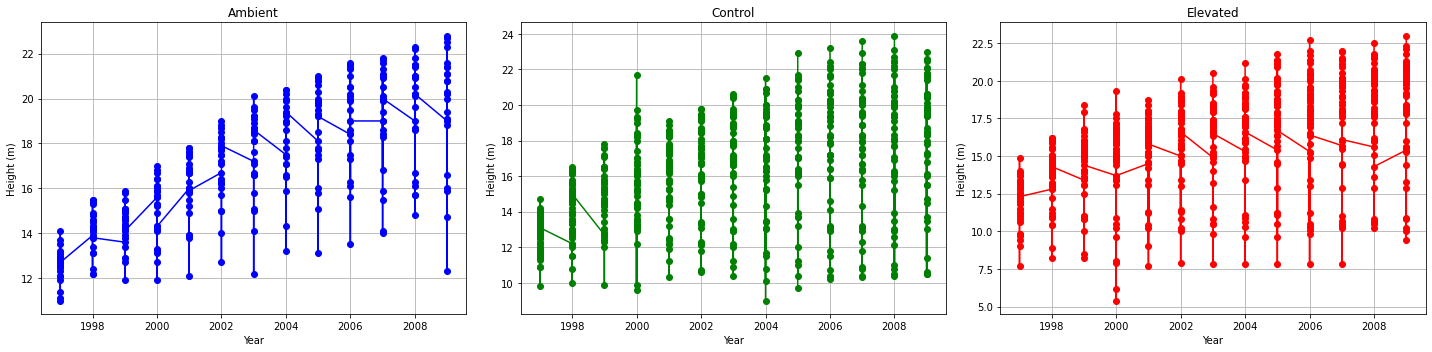

In [22]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot DataFrame 1
axs[0].plot(df_heights_plot_a['Year'], df_heights_plot_a['Height (m)'], marker='o', linestyle='-', color='b')
axs[0].set_title('Ambient')

# Plot DataFrame 2
axs[1].plot(df_heights_plot_c['Year'], df_heights_plot_c['Height (m)'], marker='o', linestyle='-', color='g')
axs[1].set_title('Control')

# Plot DataFrame 3
axs[2].plot(df_heights_plot_e['Year'], df_heights_plot_e['Height (m)'], marker='o', linestyle='-', color='r')
axs[2].set_title('Elevated')

# Add common labels
for ax in axs:
    ax.set_xlabel('Year')
    ax.set_ylabel('Height (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


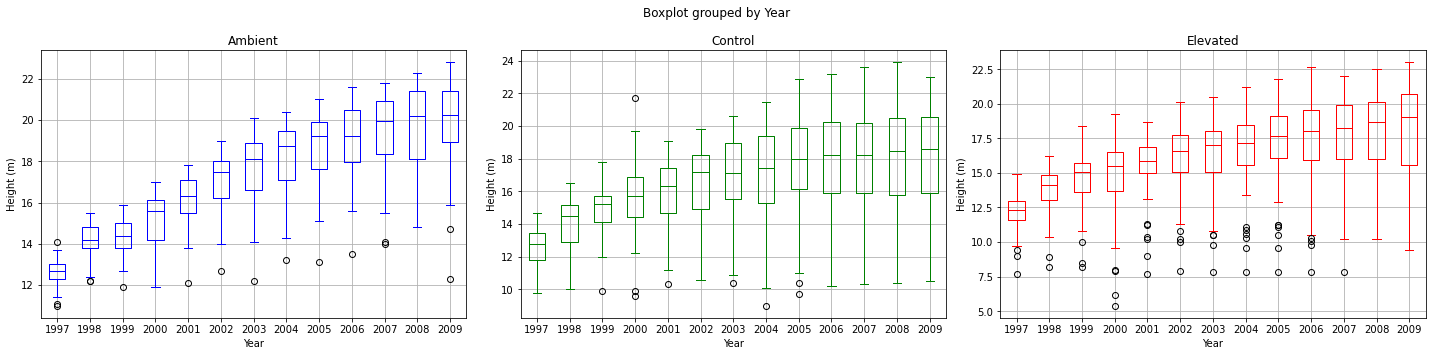

In [27]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# Plot DataFrame 1
df_heights_plot_a.boxplot(column='Height (m)', by='Year', ax=axs[0], color='b')
axs[0].set_title('Ambient')

# Plot DataFrame 2
df_heights_plot_c.boxplot(column='Height (m)', by='Year', ax=axs[1],color='g')
axs[1].set_title('Control')

# Plot DataFrame 3
df_heights_plot_e.boxplot(column='Height (m)', by='Year', ax=axs[2],color='r')
axs[2].set_title('Elevated')

# Add common labels
for ax in axs:
    ax.set_xlabel('Year')
    ax.set_ylabel('Height (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [29]:
# Group by 'Year' and calculate the average height for each year
average_height_per_year_a = df_heights_plot_a.groupby('Year')['Height (m)'].mean().reset_index()
average_height_per_year_c = df_heights_plot_c.groupby('Year')['Height (m)'].mean().reset_index()
average_height_per_year_e = df_heights_plot_e.groupby('Year')['Height (m)'].mean().reset_index()

# Display the result
print(average_height_per_year_a)


    Year  Height (m)
0   1997   12.588000
1   1998   14.120000
2   1999   14.296000
3   2000   15.068000
4   2001   16.072000
5   2002   16.956000
6   2003   17.548000
7   2004   18.154167
8   2005   18.620833
9   2006   18.970833
10  2007   19.120833
11  2008   19.470833
12  2009   19.579167


### Read Basal Areas

In [30]:
df_BA = {}

year_in = 1997

# Read the .dat file from the path into a DataFrame
file_path = paths ['BA']+ f'ba{year_in}.dat'
# Read the .dat file into a DataFrame
df_BA[year_in] = pd.read_table(file_path, skiprows=7, delim_whitespace=True)

# Select the 2: cols and calculate the average
average_ba = df_BA[year_in].iloc[:, 2:].mean(axis=1)
# Drop the all the cols used for averaging
df_BA[year_in] = df_BA[year_in].iloc[:, :2]
# use average in dataframe
df_BA[year_in]['AverageBA'] = round(average_ba,2)
#Renaming cols
df_BA[year_in]= df_BA[year_in].rename(columns={'RING':'Plot','TREE':'TreeID'})
df_BA[year_in]['Year'] = year_in

#df_BA[year_in]

In [34]:
for year_in in range(1997, 2008):
    # Read the .dat file from the path into a DataFrame
    file_path = paths ['BA']+ f'ba{year_in}.dat'
    # Read the .dat file into a DataFrame
    df_BA[year_in] = pd.read_table(file_path, skiprows=7, delim_whitespace=True)

    # Select the 2: cols and calculate the average
    average_ba = df_BA[year_in].iloc[:, 2:].mean(axis=1)
    # Drop the all the cols used for averaging
    df_BA[year_in] = df_BA[year_in].iloc[:, :2]
    df_BA[year_in]['Year'] = year_in
    # use average in dataframe
    df_BA[year_in]['AverageBA cm2'] = round(average_ba,2)
    #Renaming cols
    df_BA[year_in]= df_BA[year_in].rename(columns={'RING':'Plot','TREE':'TreeID'})


In [35]:
# Initialize an empty DataFrame to store the result
df_ba_all = pd.DataFrame()

# Loop through the list of DataFrames and concatenate them
for k in df_BA.keys():
    df_ba_all = pd.concat([df_ba_all, df_BA[k]], ignore_index=True)

In [38]:
df_ba_plot3 = df_ba_all[df_ba_all['Plot'] == 3]

In [36]:
# Only selecting values from plots per experiment
df_ba_plot_a = df_ba_all[df_ba_all['Plot'] == 3] # ambient
df_ba_plot_c = df_ba_all[df_ba_all['Plot'].isin([4,5])] # control
df_ba_plot_e = df_ba_all[df_ba_all['Plot'].isin([1,2])] # elevated


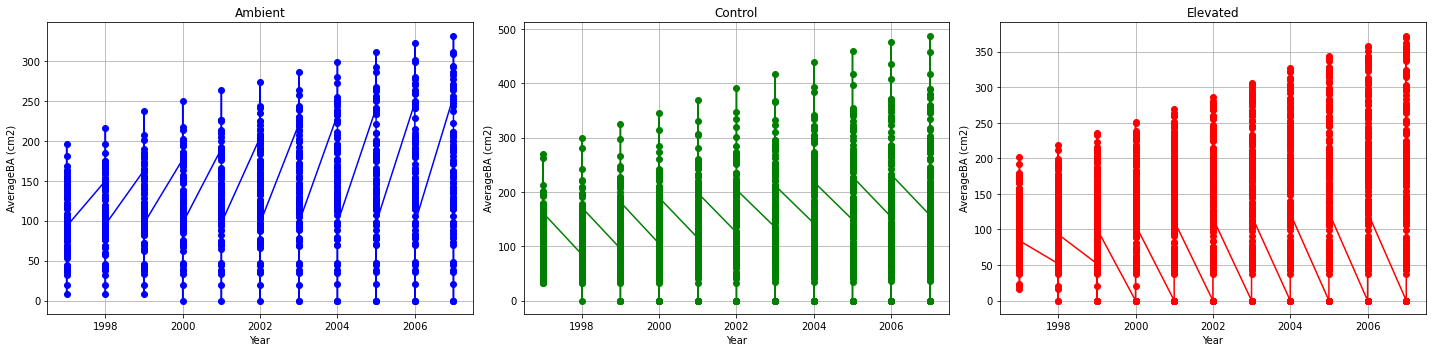

In [37]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot DataFrame 1
axs[0].plot(df_ba_plot_a['Year'], df_ba_plot_a['AverageBA cm2'], marker='o', linestyle='-', color='b')
axs[0].set_title('Ambient')

# Plot DataFrame 2
axs[1].plot(df_ba_plot_c['Year'], df_ba_plot_c['AverageBA cm2'], marker='o', linestyle='-', color='g')
axs[1].set_title('Control')

# Plot DataFrame 3
axs[2].plot(df_ba_plot_e['Year'], df_ba_plot_e['AverageBA cm2'], marker='o', linestyle='-', color='r')
axs[2].set_title('Elevated')

# Add common labels
for ax in axs:
    ax.set_xlabel('Year')
    ax.set_ylabel('AverageBA (cm2)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


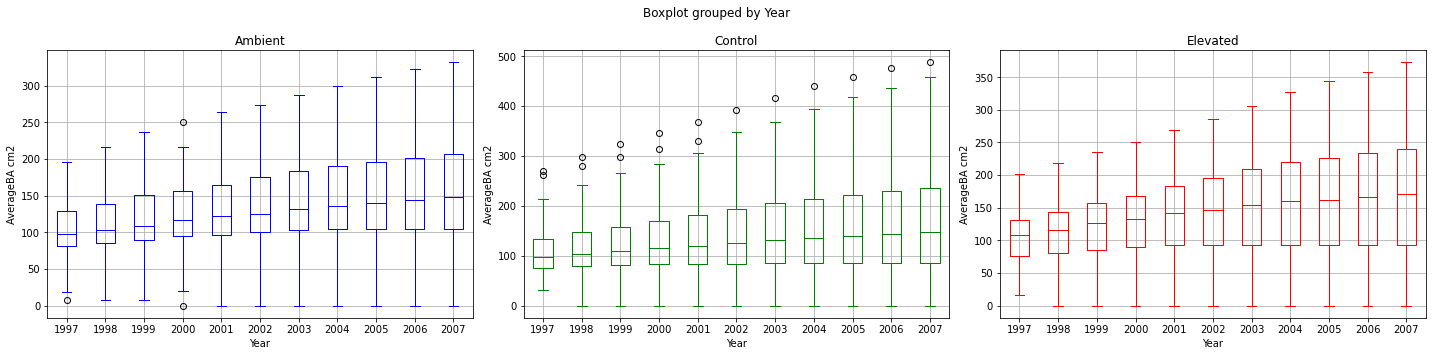

In [39]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
# Plot DataFrame 1
df_ba_plot_a.boxplot(column='AverageBA cm2', by='Year', ax=axs[0], color='b')
axs[0].set_title('Ambient')

# Plot DataFrame 2
df_ba_plot_c.boxplot(column='AverageBA cm2', by='Year', ax=axs[1],color='g')
axs[1].set_title('Control')

# Plot DataFrame 3
df_ba_plot_e.boxplot(column='AverageBA cm2', by='Year', ax=axs[2],color='r')
axs[2].set_title('Elevated')

# Add common labels
for ax in axs:
    ax.set_xlabel('Year')
    ax.set_ylabel('AverageBA cm2')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [115]:
# Merge Height and BA

# Merge DataFrames based on the 'ID' column
merged_df_a = pd.merge(df_ba_plot_a, df_heights_plot_a, on=['Plot', 'TreeID','Year'], how='inner')
merged_df_c = pd.merge(df_ba_plot_c, df_heights_plot_c, on=['Plot', 'TreeID','Year'], how='inner')
merged_df_e = pd.merge(df_ba_plot_e, df_heights_plot_e, on=['Plot', 'TreeID','Year'], how='inner')

# Drop rows with NaN values
merged_df_a.dropna(inplace=True)
merged_df_c.dropna(inplace=True)
merged_df_e.dropna(inplace=True)

# Drop rows with 0 BA values
merged_df_a = merged_df_a[merged_df_a['AverageBA cm2'] != 0]
merged_df_c = merged_df_c[merged_df_c['AverageBA cm2'] != 0]
merged_df_e = merged_df_e[merged_df_e['AverageBA cm2'] != 0]

In [116]:
merged_df_e

,Plot,TreeID,Year,AverageBA cm2,Height (m)
0,1,14,1997,90.43,12.1
1,1,15,1997,121.71,13.4
2,1,16,1997,120.00,12.1
3,1,17,1997,89.57,12.0
4,1,18,1997,81.86,11.9
...,...,...,...,...,...
545,2,73,2007,52.00,11.0
546,2,74,2007,216.57,21.4
547,2,75,2007,164.00,18.4
548,2,76,2007,355.29,21.5


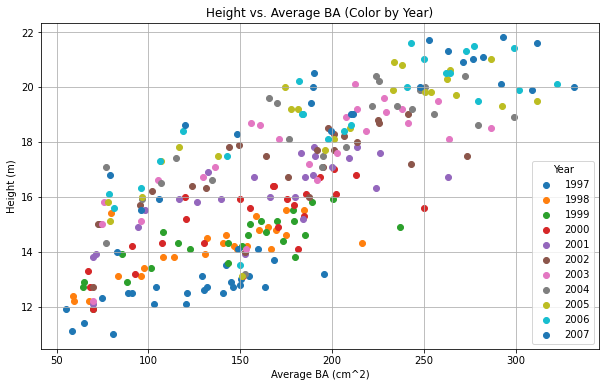

In [117]:
plt.figure(figsize=(10, 6))
ba = np.array(merged_df_a['AverageBA cm2'])
height = np.array(merged_df_a['Height (m)'])
year = np.array(merged_df_a['Year'])
for y in set(year):
    x = [height[i] for i in range(len(year)) if year[i] == y]
    y_vals = [ba[i] for i in range(len(year)) if year[i] == y]
    plt.scatter(y_vals, x, label=y)

plt.ylabel('Height (m)')
plt.xlabel('Average BA (cm^2)')
plt.title('Height vs. Average BA (Color by Year)')
plt.legend(title='Year')
plt.grid(True)
plt.show()

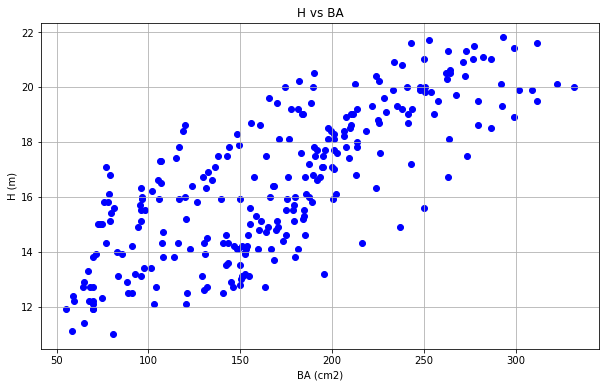

In [118]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_a['AverageBA cm2'], merged_df_a['Height (m)'], marker='o', linestyle='-', color='b')
plt.title('H vs BA')
plt.xlabel('BA (cm2)')
plt.ylabel('H (m)')
plt.grid(True)
plt.show()


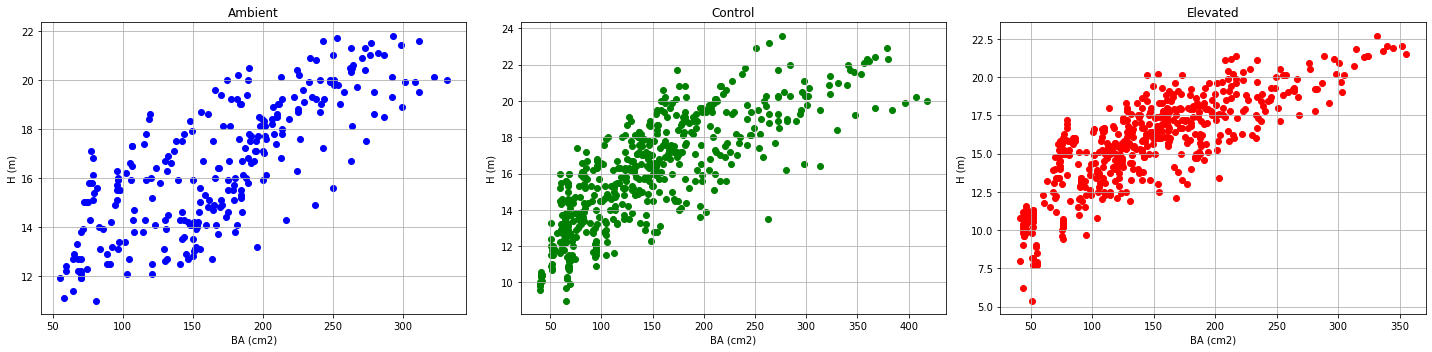

In [119]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot DataFrame 1
axs[0].scatter(merged_df_a['AverageBA cm2'], merged_df_a['Height (m)'], marker='o', linestyle='-', color='b')
axs[0].set_title('Ambient')

# Plot DataFrame 2
axs[1].scatter(merged_df_c['AverageBA cm2'], merged_df_c['Height (m)'], marker='o', linestyle='-', color='g')
axs[1].set_title('Control')

# Plot DataFrame 3
axs[2].scatter(merged_df_e['AverageBA cm2'], merged_df_e['Height (m)'], marker='o', linestyle='-', color='r')
axs[2].set_title('Elevated')

# Add common labels
for ax in axs:
    ax.set_xlabel('BA (cm2)')
    ax.set_ylabel('H (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [120]:


def area_to_diameter(area):
    diameter = math.sqrt((4 * area) / math.pi)
    return diameter

# Apply the function to the 'CircleArea' column
merged_df_a['AverageD (cm)'] = merged_df_a['AverageBA cm2'].apply(area_to_diameter)
merged_df_c['AverageD (cm)'] = merged_df_c['AverageBA cm2'].apply(area_to_diameter)
merged_df_e['AverageD (cm)'] = merged_df_e['AverageBA cm2'].apply(area_to_diameter)

# sorting DBH in ascending order
merged_df_a = merged_df_a.sort_values(by='AverageD (cm)', ascending=True)
merged_df_c = merged_df_c.sort_values(by='AverageD (cm)', ascending=True)
merged_df_e = merged_df_e.sort_values(by='AverageD (cm)', ascending=True)

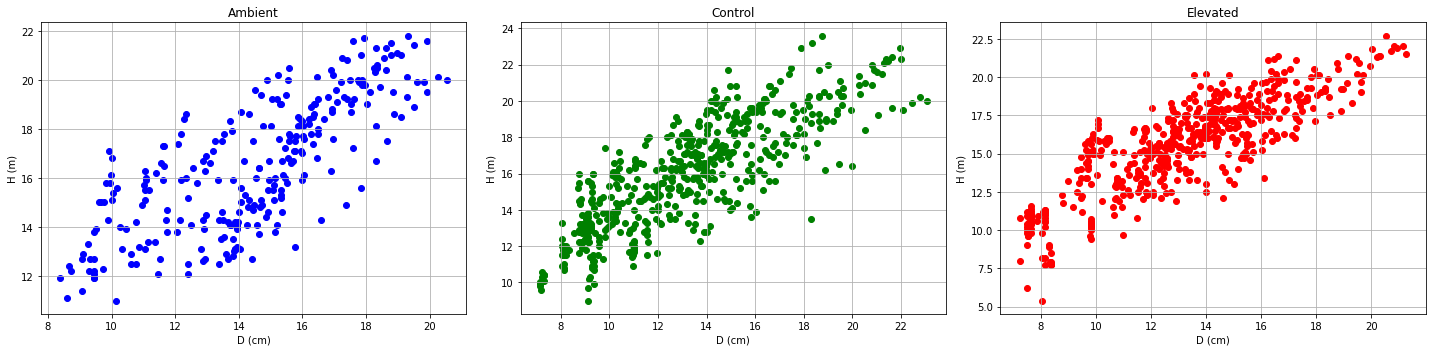

In [121]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot DataFrame 1
axs[0].scatter(merged_df_a['AverageD (cm)'], merged_df_a['Height (m)'], marker='o', linestyle='-', color='b')
axs[0].set_title('Ambient')

# Plot DataFrame 2
axs[1].scatter(merged_df_c['AverageD (cm)'], merged_df_c['Height (m)'], marker='o', linestyle='-', color='g')
axs[1].set_title('Control')

# Plot DataFrame 3
axs[2].scatter(merged_df_e['AverageD (cm)'], merged_df_e['Height (m)'], marker='o', linestyle='-', color='r')
axs[2].set_title('Elevated')

# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('H (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


# D to H allometry

### 1. Power function
h = (p1 * d**(p2))

<br>
where, <br>
h in m <br>
d in cm <br>

In [5]:
# Define the Power function
def PowerFunc(d, p1, p2):
    h = p1 * d**(p2)
    return h

[3.25823693 0.60882744]
h = 3.2582369331305103 * d ^ 0.6088274421644422


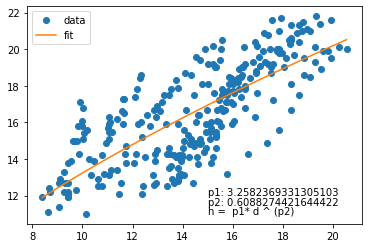

In [123]:
xdata = merged_df_a['AverageD (cm)']
ydata = merged_df_a['Height (m)']
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()
plt.text(15, 12, f"p1: {p1}")
plt.text(15, 11.5, f"p2: {p2}")
plt.text(15, 11, f"h =  p1* d ^ (p2)")
print (f"h = {p1} * d ^ {p2}")

[3.25823693 0.60882744]
h = 3.2582369331305103 * d ^ 0.6088274421644422
[3.61038253 0.57911702]
h = 3.610382531101379 * d ^ 0.5791170152662084
[2.55988644 0.70132686]
h = 2.5598864378585486 * d ^ 0.7013268568717703


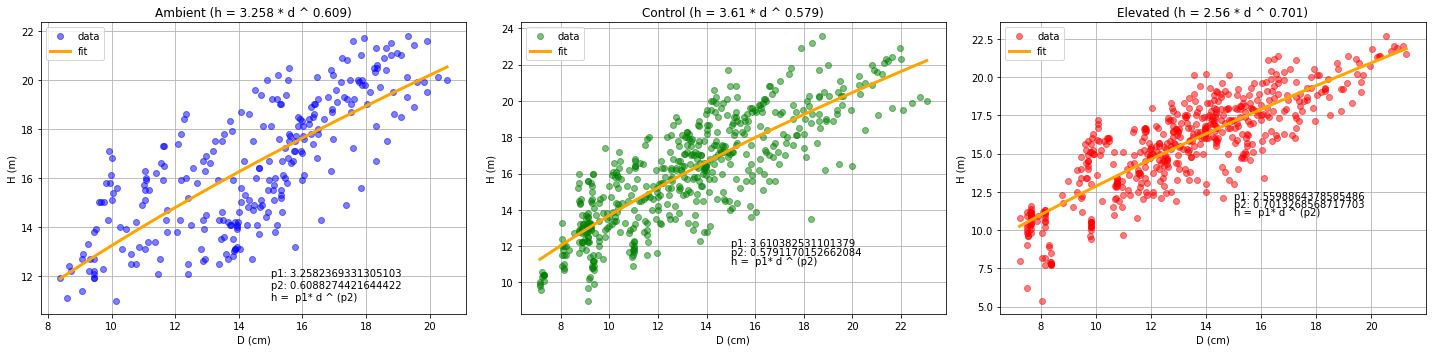

In [124]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot DataFrame 1
xdata = merged_df_a['AverageD (cm)']
ydata = merged_df_a['Height (m)']
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
axs[0].plot(xdata, ydata,  'bo', alpha=.5, label='data')
axs[0].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[0].legend()
axs[0].text(15, 12, f"p1: {p1}")
axs[0].text(15, 11.5, f"p2: {p2}")
axs[0].text(15, 11, f"h =  p1* d ^ (p2)")
print (f"h = {p1} * d ^ {p2}")
axs[0].set_title(f"Ambient (h = {round(p1,3)} * d ^ {round(p2,3)})")

#axs[0].scatter(merged_df_a['AverageD (cm)'], merged_df_a['Height (m)'], marker='o', linestyle='-', color='b')
#axs[0].set_title('Ambient')

# Plot DataFrame 2
xdata = merged_df_c['AverageD (cm)']
ydata = merged_df_c['Height (m)']
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
axs[1].plot(xdata, ydata, 'go', alpha=.5, label='data')
axs[1].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[1].legend()
axs[1].text(15, 12, f"p1: {p1}")
axs[1].text(15, 11.5, f"p2: {p2}")
axs[1].text(15, 11, f"h =  p1* d ^ (p2)")
print (f"h = {p1} * d ^ {p2}")
axs[1].set_title(f"Control (h = {round(p1,3)} * d ^ {round(p2,3)})")

# Plot DataFrame 3
xdata = merged_df_e['AverageD (cm)']
ydata = merged_df_e['Height (m)']
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
axs[2].plot(xdata, ydata, 'ro', alpha=.5, label='data')
axs[2].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[2].legend()
axs[2].text(15, 12, f"p1: {p1}")
axs[2].text(15, 11.5, f"p2: {p2}")
axs[2].text(15, 11, f"h =  p1* d ^ (p2)")
print (f"h = {p1} * d ^ {p2}")
axs[2].set_title(f"Elevated (h = {round(p1,3)} * d ^ {round(p2,3)})")

# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('H (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### 3. Obrien
h = 10**(log10(d)*p1+p2)

<br>
where, <br>
h in m <br>
d in cm <br>

In [125]:
def Obrien(d, p1, p2):
    """
    https://bg.copernicus.org/articles/16/847/2019/
    """
    h = 10 ** (np.log10(d)* p1 + p2)
    return h

[0.60882758 0.51298251]
h = 10 ** (np.log10(d)* 0.6088275755493601 + 0.512982506460188)
[0.57911698 0.55755326]
h = 10 ** (np.log10(d)* 0.5791169794336314 + 0.5575532600926594)
[0.70132681 0.40822076]
h = 10 ** (np.log10(d)* 0.7013268055689637 + 0.4082207579899999)


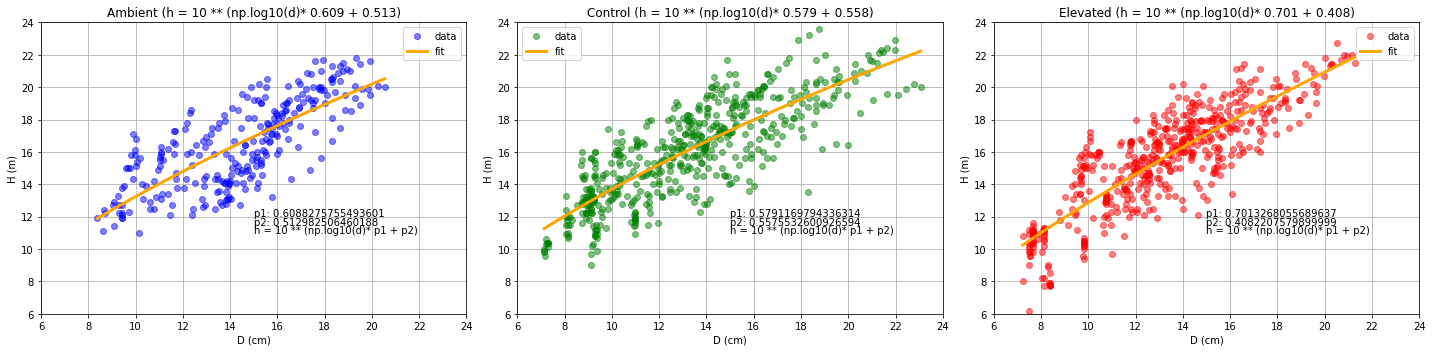

In [130]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot DataFrame 1
xdata = merged_df_a['AverageD (cm)']
ydata = merged_df_a['Height (m)']
parameters, covariance = curve_fit(Obrien, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
axs[0].plot(xdata, ydata,  'bo', alpha=.5, label='data')
axs[0].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[0].legend()
axs[0].text(15, 12, f"p1: {p1}")
axs[0].text(15, 11.5, f"p2: {p2}")
axs[0].text(15, 11, f"h = 10 ** (np.log10(d)* p1 + p2)")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[0].set_title(f"Ambient (h = 10 ** (np.log10(d)* {round(p1,3)} + {round(p2,3)})")

#axs[0].scatter(merged_df_a['AverageD (cm)'], merged_df_a['Height (m)'], marker='o', linestyle='-', color='b')
#axs[0].set_title('Ambient')

# Plot DataFrame 2
xdata = merged_df_c['AverageD (cm)']
ydata = merged_df_c['Height (m)']
parameters, covariance = curve_fit(Obrien, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
axs[1].plot(xdata, ydata, 'go', alpha=.5, label='data')
axs[1].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[1].legend()
axs[1].text(15, 12, f"p1: {p1}")
axs[1].text(15, 11.5, f"p2: {p2}")
axs[1].text(15, 11,  f"h = 10 ** (np.log10(d)* p1 + p2)")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[1].set_title(f"Control (h = 10 ** (np.log10(d)* {round(p1,3)} + {round(p2,3)})")

# Plot DataFrame 3
xdata = merged_df_e['AverageD (cm)']
ydata = merged_df_e['Height (m)']
parameters, covariance = curve_fit(Obrien, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
axs[2].plot(xdata, ydata, 'ro', alpha=.5, label='data')
axs[2].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[2].legend()
axs[2].text(15, 12, f"p1: {p1}")
axs[2].text(15, 11.5, f"p2: {p2}")
axs[2].text(15, 11,  f"h = 10 ** (np.log10(d)* p1 + p2)")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[2].set_title(f"Elevated (h = 10 ** (np.log10(d)* {round(p1,3)} + {round(p2,3)})")

# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('H (m)')
    ax.grid(True)
    ax.set_xlim(6,24)
    ax.set_ylim(6,24)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Conclusion ORNL Parameter d2h (to be filled)
For our data for Sweetgum we can use: <br>

| Power | p1 = 0.20302727 | p2 = 1.64087179| <br>

| Obrien | p1 = 1.6409 | p2= -0.6924 | <br>


# Aboveground Biomass Allometry
## Norby 2001:

(DM) = −2.24 + 0.355 * A1.3

In [129]:
def Norby_AGB (d):
    """
    d: cm

    returns
    -------
    bagw in kg
    """
    bagw = -2.24 + 0.355 * np.pi*d**2/4.0
    return bagw


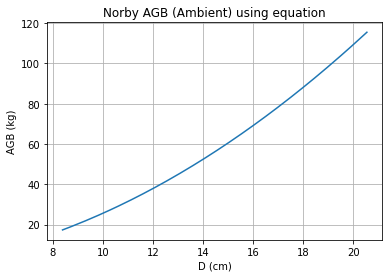

In [132]:
xdata = merged_df_a['AverageD (cm)']
Norby_agb = Norby_AGB(xdata)
plt.plot(xdata, Norby_agb, '-', label='Norby AGB')
plt.title('Norby AGB (Ambient) using equation')
plt.xlabel('D (cm)')
plt.ylabel('AGB (kg)')
plt.grid(True)

### Two Parameter Power Function
    ! =========================================================================
    ! This function calculates tree above ground biomass according to 2
    ! parameter power functions. (slope and intercepts of a log-log
    ! diameter-agb fit:
    !
    ! These relationships are typical for temperate/boreal plants in North
    ! America.  Parameters are available from Chojnacky 2014 and Jenkins 2003
    !
    ! Note that we are using an effective diameter here, as Chojnacky 2014
    ! and Jenkins use diameter at the base of the plant for "woodland" species
    ! The diameters should be converted prior to this routine if drc.
    !
    ! Input arguments:
    ! diam: effective diameter (d or drc) in cm
    ! FOR SPECIES THAT EXPECT DCM, THIS NEEDS TO BE PRE-CALCULATED!!!!
    ! Output:
    ! agb:   Total above ground biomass [kgC]

In [133]:
def PP2_bagw(d, p1, p2, c2b=2):
    bagw = (p1 * d**p2) / c2b
    return bagw
c2b = 2
# so
def PP2_bagw(d, p1, p2):
    bagw = (p1 * d**p2) / 2
    return bagw


[0.43283933 2.07913912]


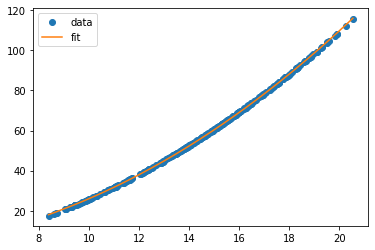

In [134]:
xdata = merged_df_a['AverageD (cm)']
ydata = Norby_agb
parameters, covariance = curve_fit(PP2_bagw, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PP2_bagw(xdata, p1, p2)
plt.plot(xdata, Norby_agb, 'o', label='data')
plt.plot(xdata, fit_y, '-', label='fit')
plt.legend()

[0.43283933 2.07913912]
agb = (0.4328393333082586 * d**2.07913912226188) / c2b
[0.4310282 2.0799378]
h = 10 ** (np.log10(d)* 0.43102819679416665 + 2.079937798467474)
[0.42357882 2.08678751]
h = 10 ** (np.log10(d)* 0.4235788151702976 + 2.0867875093771002)


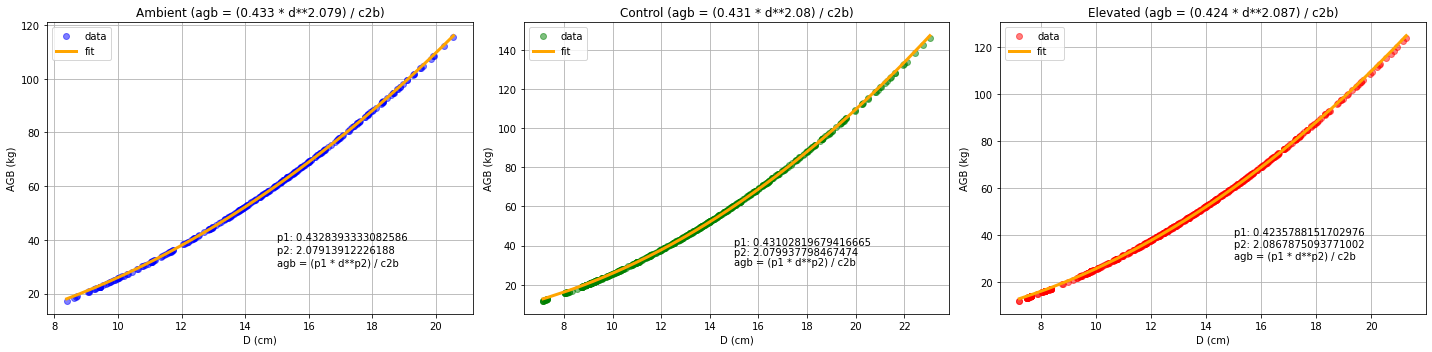

In [146]:

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot DataFrame 1
xdata = merged_df_a['AverageD (cm)']
Norby_agb = Norby_AGB(xdata)
ydata = Norby_agb
parameters, covariance = curve_fit(PP2_bagw, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PP2_bagw(xdata, p1, p2)
axs[0].plot(xdata, Norby_agb,  'bo', alpha=.5, label='data')
axs[0].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[0].legend()
axs[0].text(15, 40, f"p1: {p1}")
axs[0].text(15, 35, f"p2: {p2}")
axs[0].text(15, 30, f"agb = (p1 * d**p2) / c2b")
print (f"agb = ({p1} * d**{p2}) / c2b")
axs[0].set_title(f"Ambient (agb = ({round(p1,3)} * d**{round(p2,3)}) / c2b)")

#axs[0].scatter(merged_df_a['AverageD (cm)'], merged_df_a['Height (m)'], marker='o', linestyle='-', color='b')
#axs[0].set_title('Ambient')

# Plot DataFrame 2
xdata = merged_df_c['AverageD (cm)']
Norby_agb = Norby_AGB(xdata)
ydata = Norby_agb
parameters, covariance = curve_fit(PP2_bagw, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PP2_bagw(xdata, p1, p2)
axs[1].plot(xdata, Norby_agb, 'go', alpha=.5, label='data')
axs[1].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[1].legend()
axs[1].text(15, 40, f"p1: {p1}")
axs[1].text(15, 35, f"p2: {p2}")
axs[1].text(15, 30, f"agb = (p1 * d**p2) / c2b")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[1].set_title(f"Control (agb = ({round(p1,3)} * d**{round(p2,3)}) / c2b)")

# Plot DataFrame 3
xdata = merged_df_e['AverageD (cm)']
Norby_agb = Norby_AGB(xdata)
ydata = Norby_agb
parameters, covariance = curve_fit(PP2_bagw, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PP2_bagw(xdata, p1, p2)
axs[2].plot(xdata, Norby_agb, 'ro', alpha=.5, label='data')
axs[2].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[2].legend()
axs[2].text(15, 40, f"p1: {p1}")
axs[2].text(15, 35, f"p2: {p2}")
axs[2].text(15, 30, f"agb = (p1 * d**p2) / c2b")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[2].set_title(f"Elevated (agb = ({round(p1,3)} * d**{round(p2,3)}) / c2b)")

# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('AGB (kg)')
    ax.grid(True)
    #ax.set_xlim(6,24)
    #ax.set_ylim(6,24)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Parameters AGB Sweetgum: 
Using 2 parameter power function: <br>
p1 = 0.43146431 ; p2 = 2.08115839 <br>

Using Chave function: <br>
p1 = 1.58630521 ; p2 = 0.57085158 <br>

# DUKE
35° 58' 41.430"N, 79° 05' 39.087" W, 163 m asl ~ (36,-79)


# Duke height allometry


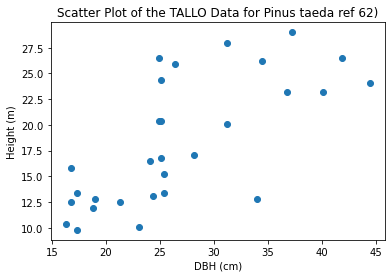

In [151]:
# ref: 62

# Your data
data = [
    (16.3, 10.4),
    (16.8, 12.5),
    (16.8, 15.8),
    (17.3, 13.4),
    (17.3, 9.8),
    (18.8, 11.9),
    (19, 12.8),
    (21.3, 12.5),
    (23.1, 10.1),
    (24.1, 16.5),
    (24.4, 13.1),
    (24.9, 20.4),
    (24.9, 26.5),
    (25.1, 24.4),
    (25.1, 16.8),
    (25.1, 20.4),
    (25.4, 15.2),
    (25.4, 13.4),
    (26.4, 25.9),
    (28.2, 17.1),
    (31.2, 20.1),
    (31.2, 28),
    (34, 12.8),
    (34.5, 26.2),
    (36.8, 23.2),
    (37.3, 29),
    (40.1, 23.2),
    (41.9, 26.5),
    (44.5, 24.1)
]

# Separate the data into x and y values
x_values, y_values = zip(*data)

# Plot the data
plt.scatter(x_values, y_values)
plt.xlabel('DBH (cm)')
plt.ylabel('Height (m)')
plt.title('Scatter Plot of the TALLO Data for Pinus taeda ref 62)')
plt.show()


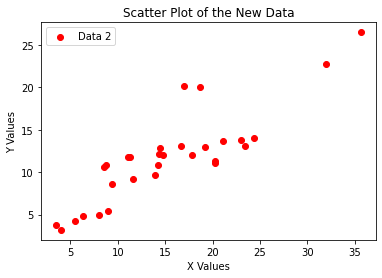

In [152]:
# ref 17

# Your new data
data2 = [
    (3.5, 3.8),
    (4, 3.2),
    (5.5, 4.3),
    (6.3, 4.8),
    (8, 4.9),
    (8.5, 10.6),
    (8.8, 10.8),
    (9, 5.4),
    (9.4, 8.6),
    (11.1, 11.8),
    (11.3, 11.8),
    (11.6, 9.2),
    (13.9, 9.7),
    (14.2, 10.8),
    (14.3, 12.1),
    (14.4, 12.8),
    (14.8, 12),
    (16.7, 13.1),
    (17, 20.2),
    (17.8, 12),
    (18.7, 20.1),
    (19.2, 13),
    (20.2, 11.1),
    (20.2, 11.3),
    (21.1, 13.7),
    (23, 13.8),
    (23.4, 13.1),
    (24.4, 14),
    (32, 22.7),
    (35.6, 26.5)
]

# Separate the data into x and y values
x_values2, y_values2 = zip(*data2)

# Plot the new data
plt.scatter(x_values2, y_values2, color='red', label='Data 2')
plt.xlabel('X Values')
plt.ylabel('Y Values')
plt.title('Scatter Plot of the New Data')
plt.legend()
plt.show()


## Power function : d2h | Duke

[1.39568721 0.78584162]
h = 1.3956872053554175 * d ^ 0.785841616044622
[1.43476856 0.77807518]
h = 1.4347685576661526 * d ^ 0.7780751802825604


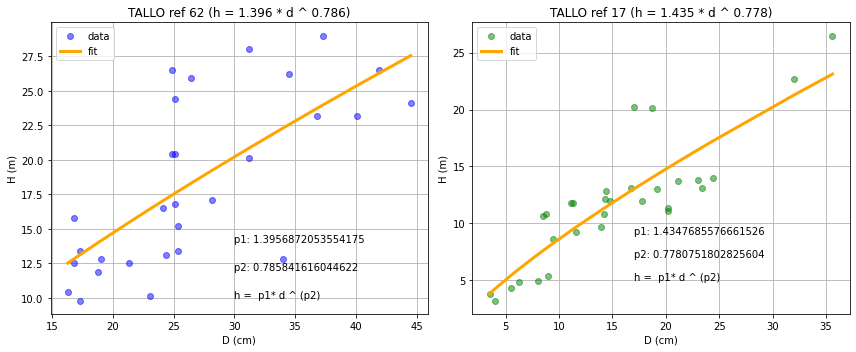

In [160]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot DataFrame 1
xdata = x_values
ydata = y_values
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
axs[0].plot(xdata, ydata,  'bo', alpha=.5, label='data')
axs[0].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[0].legend()
axs[0].text(30, 14, f"p1: {p1}")
axs[0].text(30, 12, f"p2: {p2}")
axs[0].text(30, 10, f"h =  p1* d ^ (p2)")
print (f"h = {p1} * d ^ {p2}")
axs[0].set_title(f"TALLO ref 62 (h = {round(p1,3)} * d ^ {round(p2,3)})")

# Plot DataFrame 2
xdata = x_values2
ydata = y_values2
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
axs[1].plot(xdata, ydata, 'go', alpha=.5, label='data')
axs[1].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[1].legend()
axs[1].text(17, 9, f"p1: {p1}")
axs[1].text(17, 7, f"p2: {p2}")
axs[1].text(17, 5, f"h =  p1* d ^ (p2)")
print (f"h = {p1} * d ^ {p2}")
axs[1].set_title(f"TALLO ref 17 (h = {round(p1,3)} * d ^ {round(p2,3)})")

# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('H (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


### Obrien  : d2h | Duke

[0.78584147 0.14478831]
h = 10 ** (np.log10(d)* 0.7858414684752606 + 0.14478831366101558)
[0.7780761  0.15678067]
h = 10 ** (np.log10(d)* 0.7780760992169705 + 0.15678066974070254)


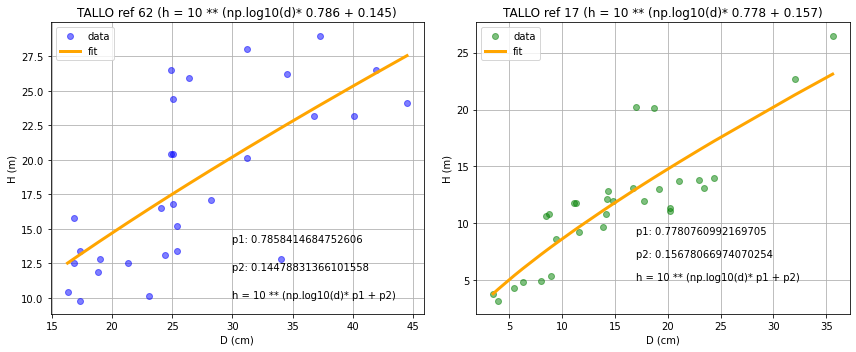

In [163]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot DataFrame 1
xdata = x_values
ydata = y_values
parameters, covariance = curve_fit(Obrien, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
axs[0].plot(xdata, ydata,  'bo', alpha=.5, label='data')
axs[0].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[0].legend()
axs[0].text(30, 14, f"p1: {p1}")
axs[0].text(30, 12, f"p2: {p2}")
axs[0].text(30, 10, f"h = 10 ** (np.log10(d)* p1 + p2)")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[0].set_title(f"TALLO ref 62 (h = 10 ** (np.log10(d)* {round(p1,3)} + {round(p2,3)})")

# Plot DataFrame 2
xdata = x_values2
ydata = y_values2
parameters, covariance = curve_fit(Obrien, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
axs[1].plot(xdata, ydata, 'go', alpha=.5, label='data')
axs[1].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[1].legend()
axs[1].text(17, 9, f"p1: {p1}")
axs[1].text(17, 7, f"p2: {p2}")
axs[1].text(17, 5,  f"h = 10 ** (np.log10(d)* p1 + p2)")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[1].set_title(f"TALLO ref 17 (h = 10 ** (np.log10(d)* {round(p1,3)} + {round(p2,3)})")

# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('H (m)')
    ax.grid(True)
    #ax.set_xlim(6,24)
    #ax.set_ylim(6,24)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Conclusion DUKE d2h 
### ref 62
Power function: [1.39568721 0.78584162] <br>
Obrien : [0.78584147 0.14478831] <br>

### ref 17
Power function: [1.43476856 0.77807518] <br>
Obrien : [0.7780761  0.15678067] <br>

## Duke Allometries from Dohyoung Kim 2019 paper
doi: 10.1111/gcb.14971 <br>

[Figure 1 : H-DBH for harvested trees](/Users/ud4/repos/GitHub/FATESFACE/FACE_data/Kim_2019_Allometry/Kim_Fig1.png)

`![1](/Users/ud4/repos/GitHub/FATESFACE/FACE_data/Kim_2019_Allometry/Kim_Fig1.png)`


<img src="/Users/ud4/repos/GitHub/FATESFACE/FACE_data/Kim_2019_Allometry/Kim_Fig1.png" alt="drawing" style="width:800px;"/>

## Duke height allometry | KIM | d2h | P. taeda


In [2]:
filepath= "/Users/ud4/repos/GitHub/FATESFACE/FACE_data/Kim_2019_Allometry/"

fname= f"{filepath}Data_for_figure_1.csv"

df = pd.read_csv(fname)

# Selecting the subset of data
subset_df_Ptaeda = df[(df['CO2'] == 'Ambient') & (df['N'] == 'Unfertilized') & (df['Species'] == 'P. taeda') & (df['Block'] == 'a') ]
subset_df_Ptaeda = df[(df['CO2'] == 'Ambient') & (df['N'] == 'Unfertilized') & (df['Species'] == 'P. taeda') ]
subset_df_Broadleaf = df[(df['CO2'] == 'Ambient') & (df['N'] == 'Unfertilized') & (df['Species'] == 'Broadleaved species') ]

subset_df_Ptaeda = subset_df_Ptaeda.sort_values(by='DBH', ascending=True)
subset_df_Broadleaf = subset_df_Broadleaf.sort_values(by='DBH', ascending=True)
#subset_df_Ptaeda

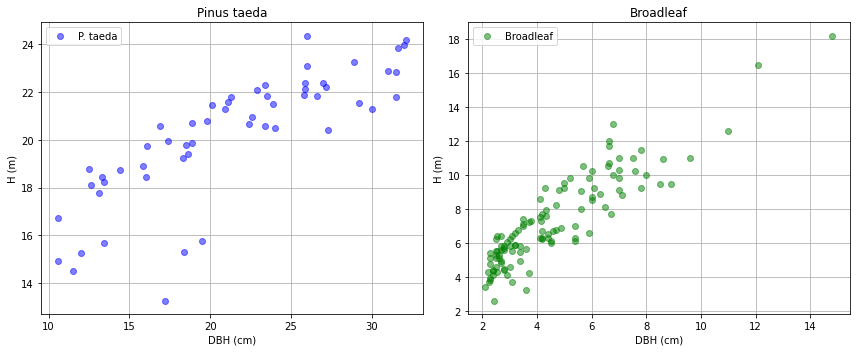

In [3]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot DataFrame 1
xdata = subset_df_Ptaeda["DBH"]
ydata = subset_df_Ptaeda["Height"]
axs[0].plot(xdata, ydata,  'bo', alpha=.5, label='P. taeda')
axs[0].legend()
axs[0].set_title(f"Pinus taeda")

# Plot DataFrame 2
xdata = subset_df_Broadleaf["DBH"]
ydata = subset_df_Broadleaf["Height"]
axs[1].plot(xdata, ydata,  'go', alpha=.5, label='Broadleaf')
axs[1].legend()
axs[1].set_title(f"Broadleaf")

# Add common labels
for ax in axs:
    ax.set_xlabel('DBH (cm)')
    ax.set_ylabel('H (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## d2h | Duke | Kim | loblolly

[7.07017762 0.34666995]
h = 7.070177619518583 * d ^ 0.3466699485003501


NameError: name 'Obrien' is not defined

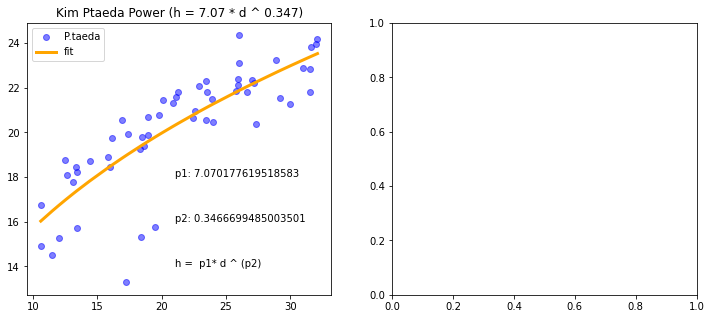

In [6]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot DataFrame 1
xdata = tuple(subset_df_Ptaeda['DBH'])
ydata = tuple(subset_df_Ptaeda['Height'])
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
axs[0].plot(xdata, ydata,  'bo', alpha=.5, label='P.taeda')
axs[0].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[0].legend()
axs[0].text(21, 18, f"p1: {p1}")
axs[0].text(21, 16, f"p2: {p2}")
axs[0].text(21, 14, f"h =  p1* d ^ (p2)")
print (f"h = {p1} * d ^ {p2}")
axs[0].set_title(f"Kim Ptaeda Power (h = {round(p1,3)} * d ^ {round(p2,3)})")


# Plot DataFrame 2
xdata = np.array(subset_df_Ptaeda['DBH'])
ydata = np.array(subset_df_Ptaeda['Height'])
parameters, covariance = curve_fit(Obrien, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
axs[1].plot(xdata, ydata, 'go', alpha=.5, label='P.taeda')
axs[1].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[1].legend()
axs[1].text(21, 18, f"p1: {p1}")
axs[1].text(21, 16, f"p2: {p2}")
axs[1].text(21, 14, f"h = 10 ** (np.log10(d)* p1 + p2)")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[1].set_title(f"Kim Ptaeda Obrien (h = 10 ** (np.log10(d)* {round(p1,3)} + {round(p2,3)})")


# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('H (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


[2.53377793 0.70312836]
h = 2.5337779275083703 * d ^ 0.7031283604174466
[0.70312836 0.40376855]
h = 10 ** (np.log10(d)* 0.7031283619355185 + 0.40376854731394196)


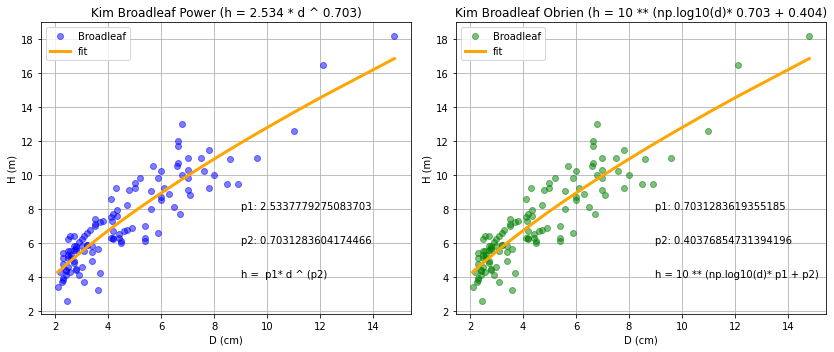

In [187]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot DataFrame 1
xdata = tuple(subset_df_Broadleaf['DBH'])
ydata = tuple(subset_df_Broadleaf['Height'])
parameters, covariance = curve_fit(PowerFunc, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PowerFunc(xdata, p1, p2)
axs[0].plot(xdata, ydata,  'bo', alpha=.5, label='Broadleaf')
axs[0].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[0].legend()
axs[0].text(9, 8, f"p1: {p1}")
axs[0].text(9, 6, f"p2: {p2}")
axs[0].text(9, 4, f"h =  p1* d ^ (p2)")
print (f"h = {p1} * d ^ {p2}")
axs[0].set_title(f"Kim Broadleaf Power (h = {round(p1,3)} * d ^ {round(p2,3)})")


# Plot DataFrame 2
xdata = np.array(subset_df_Broadleaf['DBH'])
ydata = np.array(subset_df_Broadleaf['Height'])
parameters, covariance = curve_fit(Obrien, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = Obrien(xdata, p1, p2)
axs[1].plot(xdata, ydata, 'go', alpha=.5, label='Broadleaf')
axs[1].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[1].legend()
axs[1].text(9, 8, f"p1: {p1}")
axs[1].text(9, 6, f"p2: {p2}")
axs[1].text(9, 4, f"h = 10 ** (np.log10(d)* p1 + p2)")
print (f"h = 10 ** (np.log10(d)* {p1} + {p2})")
axs[1].set_title(f"Kim Broadleaf Obrien (h = 10 ** (np.log10(d)* {round(p1,3)} + {round(p2,3)})")


# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('H (m)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## Aboveground Biomass Allometry | Kim

[Figure 6 : AGB/fiolage-DBH for harvested trees](/Users/ud4/repos/GitHub/FATESFACE/FACE_data/Kim_2019_Allometry/Kim_Fig6.png)

`![1](/Users/ud4/repos/GitHub/FATESFACE/FACE_data/Kim_2019_Allometry/Kim_Fig6.png)`


<img src="/Users/ud4/repos/GitHub/FATESFACE/FACE_data/Kim_2019_Allometry/Kim_Fig6.png" alt="drawing" style="width:800px;"/>

In [191]:
filepath= "/Users/ud4/repos/GitHub/FATESFACE/FACE_data/Kim_2019_Allometry/"

fname= f"{filepath}Data_for_figure_6.csv"

df = pd.read_csv(fname)

# Selecting the subset of data
subset_df_Ptaeda = df[(df['CO2'] == 'Ambient') & (df['N'] == 'Unfertilized') & (df['Species'] == 'P. taeda') & (df['Shade'] == 'intolerant')  ]
subset_df_Ptaeda ['agb (kg)'] = (subset_df_Ptaeda['Biomass_stem'] + subset_df_Ptaeda['Biomass_branch'])/1000
subset_df_Broadleaf = df[(df['CO2'] == 'Ambient') & (df['N'] == 'Unfertilized') & (df['Species'] == 'Broadleaved species') & (df['Shade'] == 'intolerant')  ]
subset_df_Broadleaf ['agb (kg)'] = (subset_df_Broadleaf['Biomass_stem'] + subset_df_Broadleaf['Biomass_branch'])/1000

subset_df_Ptaeda = subset_df_Ptaeda.sort_values(by='DBH', ascending=True)
subset_df_Broadleaf = subset_df_Broadleaf.sort_values(by='DBH', ascending=True)
#subset_df_Ptaeda

/var/folders/f1/01gxw8vn74q_x_rf_p5ztryjr405zq/T/ipykernel_9066/2387702665.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df_Ptaeda ['agb (kg)'] = (subset_df_Ptaeda['Biomass_stem'] + subset_df_Ptaeda['Biomass_branch'])/1000
/var/folders/f1/01gxw8vn74q_x_rf_p5ztryjr405zq/T/ipykernel_9066/2387702665.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df_Broadleaf ['agb (kg)'] = (subset_df_Broadleaf['Biomass_stem'] + subset_df_Broadleaf['Biomass_branch'])/1000


In [190]:
subset_df_Ptaeda

,Plot,Block,Species,CO2,N,Shade,DBH,H,CL,BAP,Biomass_stem,Biomass_branch,Biomass_foliage,agb (kg)
54,8,d,P. taeda,Ambient,Unfertilized,intolerant,12.50,18.78,4.22,0.177365,55436.10912,1620.120000,1055.656334,57.056229
51,8,d,P. taeda,Ambient,Unfertilized,intolerant,12.60,18.10,6.65,0.146472,59262.03994,4427.890000,2294.808514,63.689930
3,1,a,P. taeda,Ambient,Unfertilized,intolerant,13.40,15.70,3.30,0.202257,46056.89952,2866.289158,1253.644210,48.923189
38,6,c,P. taeda,Ambient,Unfertilized,intolerant,15.85,18.91,4.69,0.172242,89943.18666,4162.540000,2773.123690,94.105727
53,8,d,P. taeda,Ambient,Unfertilized,intolerant,16.10,19.75,4.87,0.274981,70646.87880,3486.550000,1438.311077,74.133429
32,5,b,P. taeda,Ambient,Unfertilized,intolerant,18.30,19.24,5.10,0.144946,99792.27954,5882.130000,2320.093827,105.674410
40,6,c,P. taeda,Ambient,Unfertilized,intolerant,22.60,20.94,6.04,0.482255,165807.58710,13806.435390,4649.173924,179.614022
33,5,b,P. taeda,Ambient,Unfertilized,intolerant,23.90,21.51,5.80,0.560726,209515.32670,12381.350000,5216.359823,221.896677
30,5,b,P. taeda,Ambient,Unfertilized,intolerant,27.00,22.37,8.54,0.666329,276438.11170,30075.794030,8716.775444,306.513906
52,8,d,P. taeda,Ambient,Unfertilized,intolerant,27.20,22.21,8.65,0.940610,296573.61930,33172.280000,10642.934050,329.745899


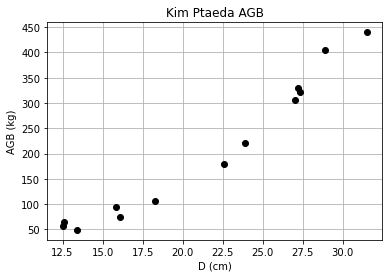

In [167]:

xdata = subset_df_Ptaeda['DBH']
ydata = subset_df_Ptaeda['agb (kg)']

plt.plot(xdata, ydata, 'ko', label='AGB' )
plt.title('Kim Ptaeda AGB')
plt.xlabel('D (cm)')
plt.ylabel('AGB (kg)')
plt.grid(True)

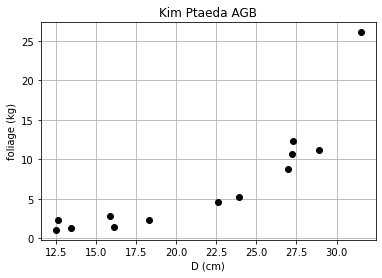

In [193]:

xdata = subset_df_Ptaeda['DBH']
ydata = subset_df_Ptaeda['Biomass_foliage']/1000

plt.plot(xdata, ydata, 'ko', label='AGB' )
plt.title('Kim Ptaeda AGB')
plt.xlabel('D (cm)')
plt.ylabel('foliage (kg)')
plt.grid(True)

[0.15588125 2.51685189]
agb = (0.15588125338644074 * d**2.516851890780666) / c2b
[0.04114212 3.08681784]
agb = (0.04114212395410317 * d**3.0868178449834702) / c2b


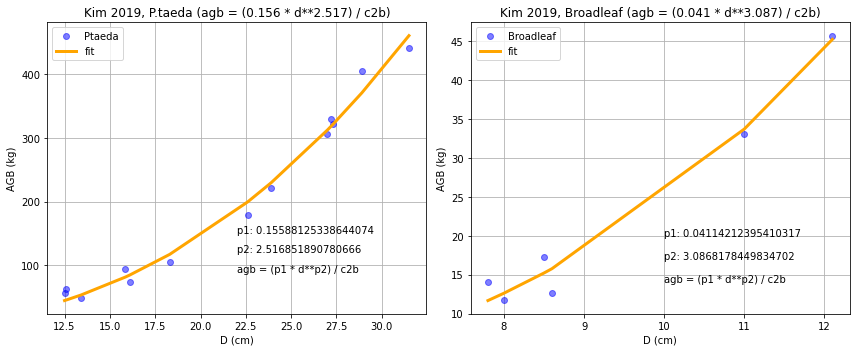

In [215]:

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot DataFrame 1
xdata = subset_df_Ptaeda['DBH']
ydata = subset_df_Ptaeda['agb (kg)']
parameters, covariance = curve_fit(PP2_bagw, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PP2_bagw(xdata, p1, p2)
axs[0].plot(xdata, ydata,  'bo', alpha=.5, label='Ptaeda')
axs[0].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[0].legend()
axs[0].text(22, 150, f"p1: {p1}")
axs[0].text(22, 120, f"p2: {p2}")
axs[0].text(22, 90, f"agb = (p1 * d**p2) / c2b")
print (f"agb = ({p1} * d**{p2}) / c2b")
axs[0].set_title(f"Kim 2019, P.taeda (agb = ({round(p1,3)} * d**{round(p2,3)}) / c2b)")


# Plot DataFrame 2
xdata = subset_df_Broadleaf['DBH']
ydata = subset_df_Broadleaf['agb (kg)']
parameters, covariance = curve_fit(PP2_bagw, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PP2_bagw(xdata, p1, p2)
axs[1].plot(xdata, ydata,  'bo', alpha=.5, label='Broadleaf')
axs[1].plot(xdata, fit_y, 'orange', lw=3, label='fit')
axs[1].legend()
axs[1].text(10, 20, f"p1: {p1}")
axs[1].text(10, 17, f"p2: {p2}")
axs[1].text(10, 14, f"agb = (p1 * d**p2) / c2b")
print (f"agb = ({p1} * d**{p2}) / c2b")
axs[1].set_title(f"Kim 2019, Broadleaf (agb = ({round(p1,3)} * d**{round(p2,3)}) / c2b)")

# Add common labels
for ax in axs:
    ax.set_xlabel('D (cm)')
    ax.set_ylabel('AGB (kg)')
    ax.grid(True)
    #ax.set_xlim(6,24)
    #ax.set_ylim(6,24)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


## d2blmax_2pwr allometry
is similar to PP2_bagw where <br> 
blmax    = (p1*d**p2) / c2b <br>
hence, I will use the same function for allometry <br>
see: https://github.com/NGEET/fates/blob/main/biogeochem/FatesAllometryMod.F90#L1434-L1458


[9.92387945e-08 5.80200232e+00]


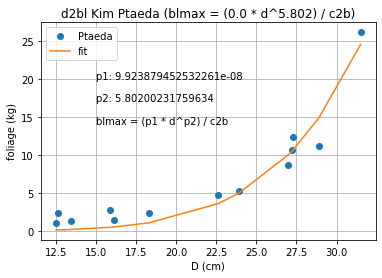

In [216]:
"""
xdata = subset_df_Ptaeda['DBH']
ydata = subset_df_Ptaeda['Biomass_foliage']/1000

plt.plot(xdata, ydata, 'ko', label='AGB' )
plt.title('Kim Ptaeda AGB')
plt.xlabel('D (cm)')
plt.ylabel('foliage (kg)')
plt.grid(True)
"""

xdata = subset_df_Ptaeda['DBH']
ydata = subset_df_Ptaeda['Biomass_foliage']/1000
parameters, covariance = curve_fit(PP2_bagw, xdata, ydata)
print (parameters)
p1 = parameters[0]
p2 = parameters[1]

fit_y = PP2_bagw(xdata, p1, p2)
plt.plot(xdata, ydata, 'o', label='Ptaeda')
plt.plot(xdata, fit_y, '-', label='fit')
plt.title (f"d2bl Kim Ptaeda (blmax = ({round(p1,3)} * d^{round(p2,3)}) / c2b)")
plt.legend()
plt.xlabel('D (cm)')
plt.ylabel('foliage (kg)')
plt.text(15, 20, f"p1: {p1}")
plt.text(15, 17, f"p2: {p2}")
plt.text(15, 14, f"blmax = (p1 * d^p2) / c2b")
plt.grid()

## Updated AGB allometry for sweetgun (Norby 2024 in review)

ln(Mstem) = -2.015 + 2.271*ln(dbh)

Exponentiating both sides:
e^(ln(Mstem)) = e^(-2.015) * e^(2.271 * ln(dbh))

Using the property of logarithms (e^(ln(x)) = x):
Mstem = e^(-2.015) * (dbh^2.271)

So, the new equation without logarithms would be:
Mstem = 0.133 * (dbh^2.271)

That means p1 = 0.133 and p2 = 2.271

## The way to estimate finerootbiomass is based on bleaf and not on BA

Norby 2024 paper has an allometry function for Mroot = 5.532 × e^(0.00519 × BA), 
should we add a subroutine with this function?

```
! ============================================================================
  ! Fine root biomass allometry wrapper
  ! ============================================================================
  
  subroutine bfineroot(d,ipft,canopy_trim,l2fr,elongf_fnrt,bfr,dbfrdd)
    
    ! -------------------------------------------------------------------------
    ! This subroutine calculates the actual target fineroot biomass
    ! based on functions that may or may not have prognostic properties. 
    ! -------------------------------------------------------------------------
    
    real(r8),intent(in)    :: d             ! plant diameter [cm]
    integer(i4),intent(in) :: ipft          ! PFT index
    real(r8),intent(in)    :: canopy_trim   ! trimming function
    real(r8),intent(in)    :: l2fr          ! leaf to fineroot scaler
                                            ! this is either a PFT parameter
                                            ! constant (when no nutrient model)
                                            ! or dynamic (with nutrient model)
    real(r8),intent(in)    :: elongf_fnrt   ! Elongation factor for fine roots
    real(r8),intent(out)   :: bfr           ! fine root biomass [kgC]
    real(r8),intent(out),optional :: dbfrdd ! change leaf bio per diameter [kgC/cm]
    
    real(r8) :: blmax      ! maximum leaf biomss per allometry
    real(r8) :: dblmaxdd
    real(r8) :: bfrmax
    real(r8) :: dbfrmaxdd
    real(r8) :: slascaler
    
    select case(int(prt_params%allom_fmode(ipft)))
    case(1) ! "constant proportionality with TRIMMED target bleaf"
       
       call blmax_allom(d,ipft,blmax,dblmaxdd)

       bfr = blmax*l2fr*canopy_trim
       
       if(present(dbfrdd))then
          dbfrdd = dblmaxdd*l2fr * canopy_trim
          
       end if
    case(2) ! "constant proportionality with UNTRIMMED target bleaf"
       
       call blmax_allom(d,ipft,blmax,dblmaxdd)

       bfr = blmax*l2fr
       if(present(dbfrdd))then
          dbfrdd = dblmaxdd*l2fr
       end if

    case DEFAULT 
       write(fates_log(),*) 'An undefined fine root allometry was specified: ', &
            prt_params%allom_fmode(ipft)
       write(fates_log(),*) 'Aborting'
       call endrun(msg=errMsg(sourcefile, __LINE__))
    end select


    ! Reduce fine-root biomass due to phenology.
    bfr = elongf_fnrt * bfr
    if (present(dbfrdd)) then
       dbfrdd = elongf_fnrt * dbfrdd
    end if


    return
  end subroutine bfineroot

```


| Allometry | PFT       | Data                         | Experiment | Model                             | P1       | P2    |
|-----------|-----------|------------------------------|------------|-----------------------------------|----------|-------|
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Ambient    | Power: h = (p1 * d**(p2))         | 3.258    | 0.609 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Control    | Power: h = (p1 * d**(p2))         | 3.61     | 0.579 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Elevated   | Power: h = (p1 * d**(p2))         | 2.56     | 0.701 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Ambient    | Obrien: h = 10**(log10(d)*p1+p2)  | 0.609    | 0.513 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Control    | Obrien: h = 10**(log10(d)*p1+p2)  | 0.579    | 0.558 |
| D2H       | Sweetgum  | FACE ORNL Sweetgum           | Elevated   | Obrien: h = 10**(log10(d)*p1+p2)  | 0.701    | 0.408 |
|           |           |                              |            |                                   |          |       |
| D2H       | Broadleaf | Kim 2019                     |            | Power: h = (p1 * d**(p2))         | 2.534    | 0.703 |
| D2H       | Broadleaf | Kim 2019                     |            | Obrien: h = 10**(log10(d)*p1+p2)  | 0.703    | 0.404 |
|           |           |                              |            |                                   |          |       |
| D2H       | Loblolly  | TALLO ref 17                 |            | Power: h = (p1 * d**(p2))         | 1.435    | 0.788 |
| D2H       | Loblolly  | TALLO ref 62                 |            | Power: h = (p1 * d**(p2))         | 1.396    | 0.786 |
| D2H       | Loblolly  | Kim 2019                     |            | Power: h = (p1 * d**(p2))         | 7.07     | 0.347 |
| D2H       | Loblolly  | TALLO ref 17                 |            | Obrien: h = 10**(log10(d)*p1+p2)  | 0.778    | 0.157 |
| D2H       | Loblolly  | TALLO ref 62                 |            | Obrien: h = 10**(log10(d)*p1+p2)  | 0.786    | 0.145 |
| D2H       | Loblolly  | Kim 2019                     |            | Obrien: h = 10**(log10(d)*p1+p2)  | 0.347    | 0.849 |
|           |           |                              |            |                                   |          |       |
| D2AGB     | Sweetgum  | Norby 2001 Paper             |            | Power: agb = (p1 * d**p2) / c2b   | 0.433    | 2.079 |
| D2AGB     | Sweetgum  | Norby 2024 Paper (in review) |            | Power: agb = (p1 * d**p2) / c2b   | 0.133    | 2.271 |
|           |           |                              |            |                                   |          |       |
| D2AGB     | Loblolly  | Kim 2019                     |            | Power: agb = (p1 * d**p2) / c2b   | 0.156    | 2.517 |
| D2AGB     | Broadleaf | Kim 2019                     |            | Power: agb = (p1 * d**p2) / c2b   | 0.041    | 3.087 |
|           |           |                              |            |                                   |          |       |
| D2BL      | Loblolly  | Kim 2019                     |            | Power: blmax = (p1 * d**p2) / c2b | 9.92E-08 | 5.802 |